In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
import torchvision

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
VOCAB_SIZE = 500
# MAX_PER_CLASS = 50

In [4]:
# Load CIFAR-10 and convert to grayscale (original 32x32 resolution)
def load_cifar10(limit=1000):
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
    images, labels = [], []
    for i in range(min(limit, len(dataset))):
        img_tensor, label = dataset[i]
        img = transforms.ToPILImage()(img_tensor).convert('L')  # grayscale PIL image
        img = np.array(img)  # original 32x32 numpy array
        images.append(img)
        labels.append(dataset.classes[label])
    return images, labels
    
# Load Caltech101 using pre-downloaded data (original resolution)
def load_caltech101(path='../data/101_ObjectCategories', max_per_class=10):
    images, labels = [] , []
    class_names = sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d)) and not d.startswith("BACKGROUND")])
    for label in class_names:
        img_dir = os.path.join(path, label)
        count = 0
        for file in os.listdir(img_dir):
            if count >= max_per_class:
                break
            img_path = os.path.join(img_dir, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)  # keep original resolution
                labels.append(label)
                count += 1
    return images, labels

In [5]:
def extract_sift_descriptors(img_set):
    sift = cv2.SIFT_create()
    descriptors_list = []
    labels = []
    for img, label in img_set:
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
            labels.append(label)

    return descriptors_list, labels

def build_vocabulary(descriptors_list, k=100):
    all_descriptors = np.vstack(descriptors_list)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans

def extract_features(descriptors_list, kmeans):
    k = kmeans.n_clusters
    features = []
    for descriptors in descriptors_list:
        hist = np.zeros(k)
        if descriptors is not None:
            words = kmeans.predict(descriptors)
            for w in words:
                hist[w] += 1
        features.append(hist)
    return np.array(features)


In [6]:
def train_model(dataset, k=100):
    # Load data
    dataset = 'caltech101'  # or 'cifar10'
    if dataset == 'caltech101':
        images, labels = load_caltech101()
    else:
        images, labels = load_cifar10()

    img_set = zip(images, labels)

    descriptors_list, labels = extract_sift_descriptors(img_set)
    kmeans = build_vocabulary(descriptors_list, k=k)
    features = extract_features(descriptors_list, kmeans)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Train SVM
    clf = SVC(kernel='rbf', C=5, gamma='scale')
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    return y_test, preds

In [7]:
def train_model(dataset, k=100):
    if dataset == 'caltech101':
        images, labels = load_caltech101()
    else:
        images, labels = load_cifar10()

    # Encode labels as integers
    le = LabelEncoder()
    labels = le.fit_transform(labels)

    img_set = zip(images, labels)
    descriptors_list, labels = extract_sift_descriptors(img_set)
    kmeans = build_vocabulary(descriptors_list, k=k)
    features = extract_features(descriptors_list, kmeans)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    models = {
        "SVC": (SVC(), {
            'C': [1, 5, 10],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf']
        }),
        "RandomForest": (RandomForestClassifier(random_state=42), {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20]
        }),
        "XGBoost": (XGBClassifier(eval_metric='mlogloss', verbosity=0, random_state=42), {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.1, 0.01]
        })
    }

    results = {}
    for name, (model, param_grid) in models.items():
        print(f"\nTuning {name} with GridSearchCV...")
        grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', verbose=0)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        preds = best_model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        print(f"{name} Best Accuracy: {acc * 100:.2f}%")
        print(f"Best Params: {grid.best_params_}")
        results[name] = (y_test, preds, acc)

    return results


In [8]:
def evaluate_results(results):
    for model_name, (y_true, y_pred, acc) in results.items():
        print(f"\n=== Evaluation for {model_name} ===")
        print(f"Accuracy: {acc * 100:.2f}%")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=False, fmt='d', cmap='viridis')
        plt.title(f"{model_name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

In [9]:
res_1 = train_model("cifar10", k=100)


Tuning SVC with GridSearchCV...
SVC Best Accuracy: 25.00%
Best Params: {'C': 5, 'gamma': 'scale', 'kernel': 'rbf'}

Tuning RandomForest with GridSearchCV...
RandomForest Best Accuracy: 27.50%
Best Params: {'max_depth': 20, 'n_estimators': 200}

Tuning XGBoost with GridSearchCV...
XGBoost Best Accuracy: 23.50%
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [10]:
res_2 = train_model("cifar10", k=300)


Tuning SVC with GridSearchCV...
SVC Best Accuracy: 26.50%
Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Tuning RandomForest with GridSearchCV...
RandomForest Best Accuracy: 27.00%
Best Params: {'max_depth': 20, 'n_estimators': 200}

Tuning XGBoost with GridSearchCV...
XGBoost Best Accuracy: 26.50%
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [11]:
res_3 = train_model("caltech101", k=100)


Tuning SVC with GridSearchCV...
SVC Best Accuracy: 14.85%
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Tuning RandomForest with GridSearchCV...
RandomForest Best Accuracy: 16.34%
Best Params: {'max_depth': None, 'n_estimators': 200}

Tuning XGBoost with GridSearchCV...
XGBoost Best Accuracy: 13.37%
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


In [9]:
res_4 = train_model("caltech101", k=300)


Tuning SVC with GridSearchCV...
SVC Best Accuracy: 17.82%
Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Tuning RandomForest with GridSearchCV...
RandomForest Best Accuracy: 16.34%
Best Params: {'max_depth': 20, 'n_estimators': 200}

Tuning XGBoost with GridSearchCV...
XGBoost Best Accuracy: 12.87%
Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}



=== Evaluation for SVC ===
Accuracy: 25.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.46      0.46        24
           1       0.29      0.50      0.37        18
           2       0.22      0.23      0.22        22
           3       0.00      0.00      0.00        13
           4       0.17      0.10      0.12        20
           5       0.26      0.38      0.31        16
           6       0.21      0.11      0.15        27
           7       0.11      0.10      0.10        21
           8       0.32      0.39      0.35        18
           9       0.21      0.24      0.22        21

    accuracy                           0.25       200
   macro avg       0.22      0.25      0.23       200
weighted avg       0.23      0.25      0.23       200



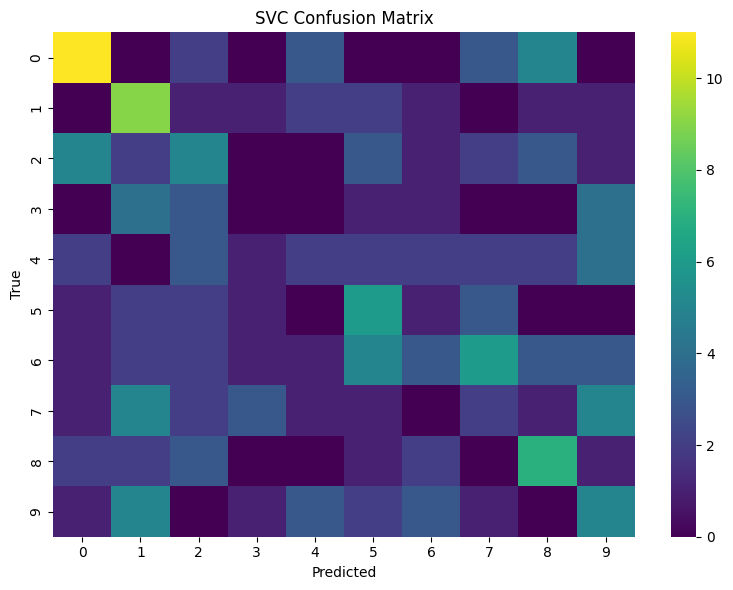


=== Evaluation for RandomForest ===
Accuracy: 27.50%

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.38      0.38        24
           1       0.27      0.50      0.35        18
           2       0.25      0.23      0.24        22
           3       0.06      0.08      0.07        13
           4       0.21      0.15      0.18        20
           5       0.20      0.12      0.15        16
           6       0.31      0.19      0.23        27
           7       0.27      0.19      0.22        21
           8       0.27      0.56      0.36        18
           9       0.50      0.33      0.40        21

    accuracy                           0.28       200
   macro avg       0.27      0.27      0.26       200
weighted avg       0.29      0.28      0.27       200



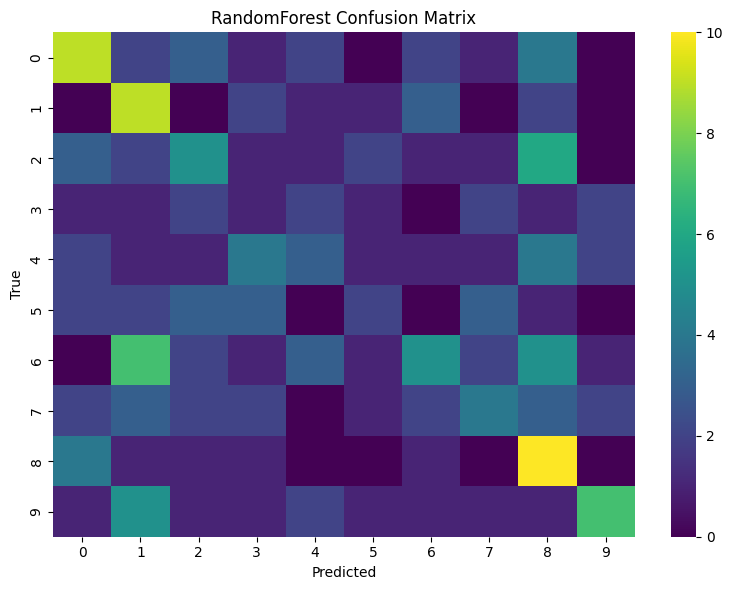


=== Evaluation for XGBoost ===
Accuracy: 23.50%

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.42      0.41        24
           1       0.24      0.44      0.31        18
           2       0.21      0.23      0.22        22
           3       0.09      0.08      0.08        13
           4       0.25      0.15      0.19        20
           5       0.25      0.25      0.25        16
           6       0.11      0.07      0.09        27
           7       0.12      0.10      0.11        21
           8       0.27      0.44      0.33        18
           9       0.27      0.19      0.22        21

    accuracy                           0.23       200
   macro avg       0.22      0.24      0.22       200
weighted avg       0.22      0.23      0.22       200



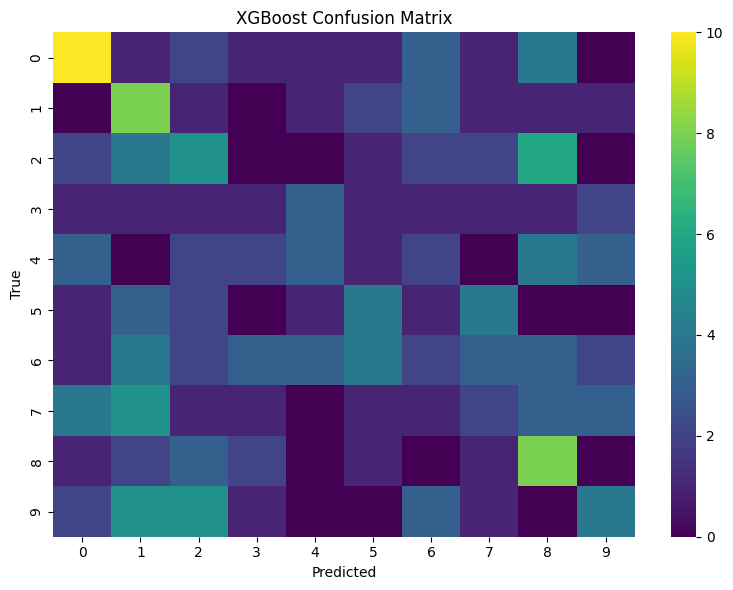

In [14]:
evaluate_results(res_1)

In [24]:
img, lbl = load_cifar10()
le = LabelEncoder()
labels = le.fit_transform(lbl)
# le.inverse_transform([0])

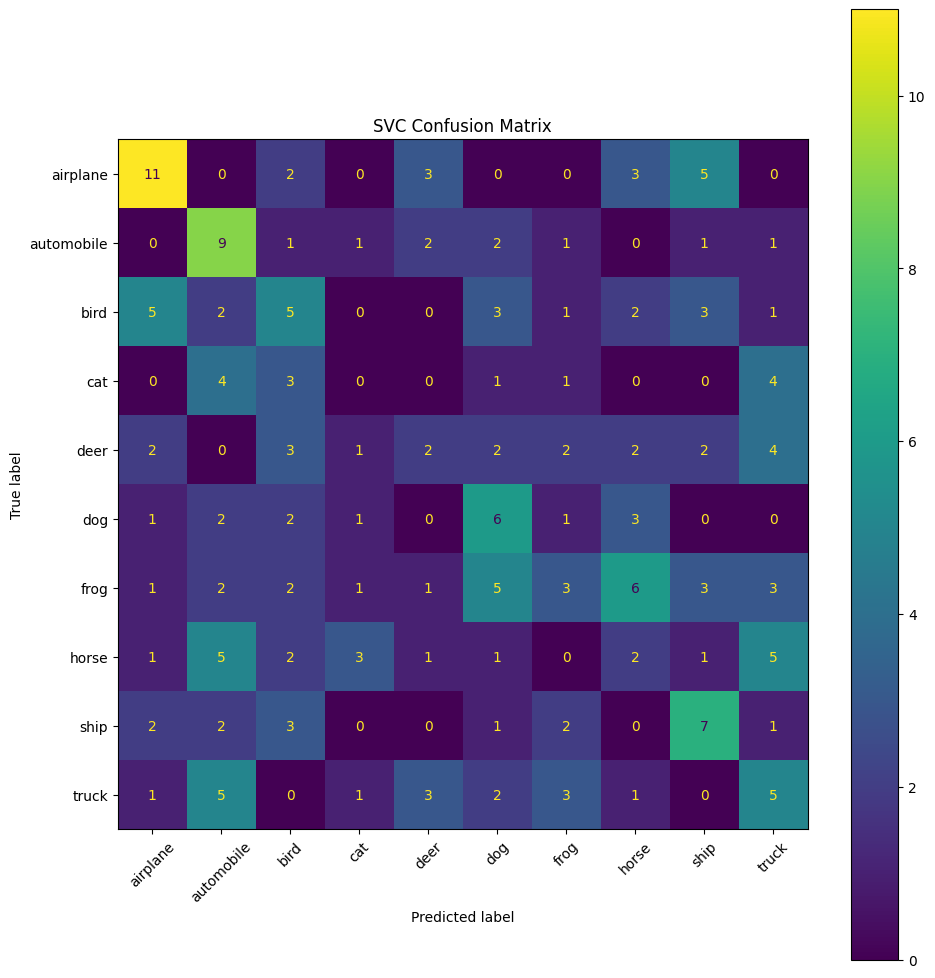

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix_with_labels(y_true, y_pred, label_encoder, title='SVC Confusion Matrix'):
    """
    Plots a confusion matrix with original class labels (decoded from LabelEncoder).
    
    Args:
        y_true (list or np.array): Encoded true labels
        y_pred (list or np.array): Encoded predicted labels
        label_encoder (LabelEncoder): The fitted LabelEncoder object
        title (str): Title for the plot
    """
    class_labels = label_encoder.classes_
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap='viridis', xticks_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()

y_test, y_pred = res_1["SVC"][0], res_1["SVC"][1]
plot_confusion_matrix_with_labels(y_test, y_pred, le)

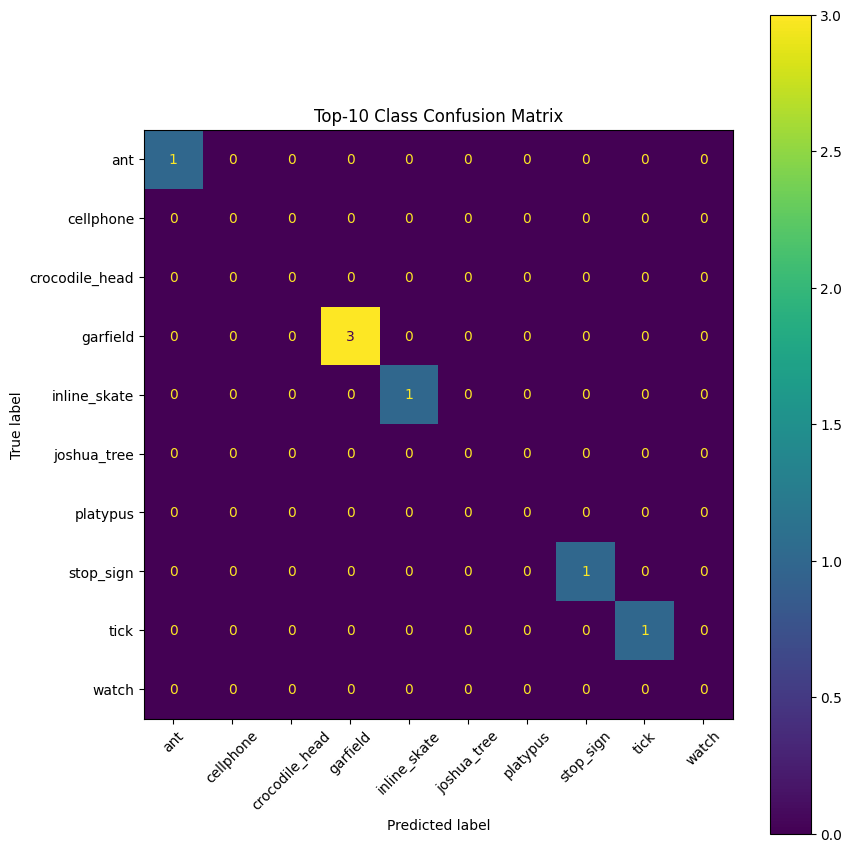

In [13]:
import os
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ✅ Step 1: Load Caltech101 dataset (grayscale, original resolution)
def load_caltech101(path='../data/101_ObjectCategories', max_per_class=10):
    images, labels = [], []
    class_names = sorted([
        d for d in os.listdir(path) 
        if os.path.isdir(os.path.join(path, d)) and not d.startswith("BACKGROUND")
    ])
    for label in class_names:
        img_dir = os.path.join(path, label)
        count = 0
        for file in os.listdir(img_dir):
            if count >= max_per_class:
                break
            img_path = os.path.join(img_dir, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                labels.append(label)
                count += 1
    return images, labels

# ✅ Step 2: Define function to plot Top-10 confusion matrix
def plot_top10_confusion_matrix(y_true_enc, y_pred_enc, label_encoder, title="Top-10 Class Confusion Matrix"):
    # Decode encoded labels into original strings
    y_true_str = label_encoder.inverse_transform(y_true_enc)
    y_pred_str = label_encoder.inverse_transform(y_pred_enc)

    # Get top 10 most frequent labels based on y_true
    counts = Counter(y_true_str)
    top10_classes = [cls for cls, _ in counts.most_common(10)]

    # Create mask: keep only samples where both true and predicted are in top 10
    mask = np.isin(y_true_str, top10_classes) & np.isin(y_pred_str, top10_classes)
    y_true_top10 = np.array(y_true_str)[mask]
    y_pred_top10 = np.array(y_pred_str)[mask]

    # Encode again using only top-10
    top10_encoder = LabelEncoder().fit(top10_classes)
    y_true_encoded = top10_encoder.transform(y_true_top10)
    y_pred_encoded = top10_encoder.transform(y_pred_top10)

    # Compute confusion matrix with all top-10 labels
    cm = confusion_matrix(y_true_encoded, y_pred_encoded, labels=range(10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top10_encoder.classes_)

    fig, ax = plt.subplots(figsize=(9, 9))
    disp.plot(ax=ax, cmap='viridis', xticks_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ✅ Step 3: Load data + encode labels
img, lbl = load_caltech101()
le = LabelEncoder()
labels = le.fit_transform(lbl)

# ✅ Step 4: Get model predictions (example using your res_4["SVC"])
# NOTE: This assumes res_4["SVC"] = (y_test, y_pred), both label-encoded
y_test_enc, y_pred_enc = res_4["SVC"][0], res_4["SVC"][1]

# ✅ Step 5: Plot Top-10 confusion matrix
plot_top10_confusion_matrix(y_test_enc, y_pred_enc, label_encoder=le)
